# Apache Arrow

-  Development platform for in-memory analytics
-  Process and move data faster
-  Standarized language indepedent columnar format for flat and hierarchical data
-  Zero-copy shared memory and RPC-based data movement


- Show Arrow picture
     https://www.tutorialandexample.com/wp-content/uploads/2019/06/Introduction-to-Apache-Arrow.png
     
     
References:

https://arrow.apache.org/docs/index.html
     

# Arrow Columnar Format

- Language agnostic in-memory data structure

- Data adjacency for sequential access
- Constant Random Access
- SIMD and vectorization friendly
- 'Pointer-Swizling' avoided resulting in zero-copy access in share memory

Source:
    https://arrow.apache.org/docs/format/Columnar.html

# PyArrow

- Memory Management
- Data Types 
- Compute Functions
- Plasma In-memory Object store
- Numpy Integration
- Pandas Integration

- Parquet and Arrow


# Memory management

-  Buffer 
-  Memory Pools
-  Input/Output Streams
-  On-Disk and Memory mapping Files

# Memory View and Buffer protocol

- Buffer protocol provides access to internal representation of memory
- MemoryView is a mechanism to access this internal mechanism from Python land.
- Let's look at some examples



In [1]:
data = b'hello world'
m = memoryview(data)
m.obj


In [2]:
print(f'{m[0]=}, {bytes(m[0:1])=}')

In [3]:
# mutate memory view
data = bytearray('abcefgh', encoding='utf-8')
m = memoryview(data)
print(f'{m[-1]=}')

# some assignments
k = m[-3:]  # a slice of memory view is a zero-copy
m[-1] = 72 # capital H

print(f'data after update = {data}')

print(bytes(k))

In [4]:
# Pyarrow.buffer

import pyarrow as pa

data = b'abcdefgh'
data_buffer = pa.py_buffer(data)

z = data_buffer[-3:]
z.to_pybytes

<function Buffer.to_pybytes>

In [5]:
# Memory managed in Memory Pools

new_buffer = pa.allocate_buffer(4000)
print(pa.total_allocated_bytes())

new_buffer

#new_buffer[0] = None # Does not support assignment

4032


In [6]:
# Reading/Writing to these buffers

buffer_1 = memoryview(b"hello world")
stream = pa.input_stream(buffer_1)
print(stream.read(5))


b'hello'


In [7]:
# Reading/Writing To/From In-Memory Buffer

write = pa.BufferOutputStream()
write.write(b'hello world')

# write.getvalue # Finalize output stream and return stream as buffer
buffer = write.getvalue()

print('Type of buffer=', type(buffer))

reader = pa.BufferReader(buffer)
reader.read_at(6, 5)

# write.write(b'hello world, again') # not writing possible once read



Type of buffer= <class 'pyarrow.lib.Buffer'>


b' world'

# Data Types and In-Memory Data Model

-  Columnar data structures = type meta-data + memory buffers
-  pyarrow.DataType
-  pyarrow.Schema - collections of pyarrow.DataType
-  pyarrow.Arrays - atomic, contiguous columnar data structures composed from arrow buffer objects
-  pyarrow.RecordBatch - collection of ArrayObjects of a particular schema
-  pyarrow.Table  - Each column consists of pyarrow.Array




# Supported Types (Richer than what you store in Pandas/Numpy)

-  Fixed-length primitives - number, floats, timestamp etc
-  Variable-lenght primitives (strings)
-  Nested-Types (list, struct, union)
-  Dictionary types ( we wont cover this)
  
 

In [8]:
# Examples of types

print(pa.int32())
print(pa.float64())

int32
double


In [9]:
# Using these types - Define Fields


# Types used to define schema (metadata)

f1 = pa.field('country_count', pa.int32())



In [10]:
# Define collection of fields as structs

f1 = pa.field('idbbunique', pa.int32())
f2 = pa.field('price', pa.float64())
f3 = pa.field('data_date', pa.date64())
# Add nested lists?

new_struct =  pa.struct([f1, f2, f3])

new_struct


StructType(struct<idbbunique: int32, price: double, data_date: date64[ms]>)

In [11]:
# One can also define Schemas (to be used with Table/Record Batch)

schema = pa.schema([('idbb_unique', pa.int32()), ('price', pa.float64()), ('data_data', pa.date64())])
schema

# schema's can also have nested structures



idbb_unique: int32
price: double
data_data: date64[ms]

In [12]:
int_arr = pa.array([100, 200, 300, None], type=pa.uint32())
print(f'{int_arr=}')

float_arr = pa.array([100.1, 200.0, 300.0, None])
print(f'{float_arr=}')

# check out the NULLs
print(f'{float_arr[-1]=}')

float_arr.null_count

int_arr=<pyarrow.lib.UInt32Array object at 0x7f58c7e97e80>
[
  100,
  200,
  300,
  null
]
float_arr=<pyarrow.lib.DoubleArray object at 0x7f58c7e97ee0>
[
  100.1,
  200,
  300,
  null
]
float_arr[-1]=<pyarrow.DoubleScalar: None>


1

In [13]:
# Slicing is zero-copy operation, since Array's are readonly

float_arr[1:3]

[
  200,
  300
]

# Time to talk about None and Nans!

In [14]:
x = int_arr[-1]

x.is_valid


False

# Union/Category


# Record Batches

- Collection of equal length array instances
- Remember (arrays are just contiguous elements of primitives, structs, unions)


In [15]:
# all elements should be of same length
data = [
    pa.array([1,2,3,4]),
    pa.array(['foo', 'bar','baz', None]),
    pa.array([True, None, False, True])
]
batch = pa.RecordBatch.from_arrays(data, ['f0', 'f1', 'f2'])



print(f'{batch.num_columns=}, {batch.num_rows=}, {batch.schema=}, {batch[1]}')


batch.num_columns=3, batch.num_rows=4, batch.schema=f0: int64
f1: string
f2: bool, [
  "foo",
  "bar",
  "baz",
  null
]


# Slicing into Record Batches

-  Zero-copy!

In [16]:
print(f'{batch[0:2][1]=}, {batch[0:2][0]=}')

batch[0:2][1]=<pyarrow.lib.StringArray object at 0x7f58c7c229a0>
[
  "foo",
  "bar"
], batch[0:2][0]=<pyarrow.lib.Int64Array object at 0x7f58c7c229a0>
[
  1,
  2
]


# Tables

- Grouping RecordBatches into one logical unit
- Needed so that record-batches arriving from different processes need not be copied/reorganized again

In [17]:
batches = [batch] * 5
table = pa.Table.from_batches(batches)

table[0]

[
  [
    1,
    2,
    3,
    4
  ],
  [
    1,
    2,
    3,
    4
  ],
  [
    1,
    2,
    3,
    4
  ],
  [
    1,
    2,
    3,
    4
  ],
  [
    1,
    2,
    3,
    4
  ]
]

In [18]:
table_1 = [table]*2

table_all = pa.concat_tables(table_1)
table_all[0]

[
  [
    1,
    2,
    3,
    4
  ],
  [
    1,
    2,
    3,
    4
  ],
  [
    1,
    2,
    3,
    4
  ],
  [
    1,
    2,
    3,
    4
  ],
  [
    1,
    2,
    3,
    4
  ],
  [
    1,
    2,
    3,
    4
  ],
  [
    1,
    2,
    3,
    4
  ],
  [
    1,
    2,
    3,
    4
  ],
  [
    1,
    2,
    3,
    4
  ],
  [
    1,
    2,
    3,
    4
  ]
]

In [19]:
# Nested columns
# all elements should be of same length

a = pa.array([1,2,3,4], type=pa.uint16())

In [20]:
# Numpy Integration


In [21]:
# Pandas Frame Vs Arrow Table

- Both needs columns to be of same length
- Columns (arrays in Arrow) can have nested types like struct etc (first class objects)
-  

SyntaxError: invalid syntax (<ipython-input-21-8e24fc69e24c>, line 3)

In [ ]:
# The plasma in-memory data store

In [ ]:
# relationship to Parquet

In [ ]:
# More examples

In [ ]:
# all elements should be of same length
data = [
    pa.array([1,2,3,4]),
    #pa.array(['foo', 'bar','baz', None]),
    #pa.array([True, None, False, True])
]
batch = pa.RecordBatch.from_arrays(data, ['f0']) # 'f1', 'f2'])

table = pa.Table.from_batches([batch]*2)

df = table.to_pandas(split_blocks=True, self_destruct=True)
df.loc[0, 'f0'] = 1000

df



In [ ]:
import pyarrow.compute as pc
a = pc.sum(batch[0])

b = pc.multiply(batch[0], batch[0])
print(b)

pc.add(batch[0], batch[0])

pc.equal(batch[0],1)

l = pc.SetLookupOptions(value_set=pa.array([1]))
            
pc.is_in(data[0], options=l)

pa.scalar(1)
           

# Feather vs Parquet

- https://stackoverflow.com/questions/48083405/what-are-the-differences-between-feather-and-parquet

In [ ]:
# Example

schema = pa.schema([('sec1', pa.float64()),
                    ('sec2', pa.float64()),
                    ('sec3', pa.float64())])

data = [pa.array([101, 102, 99]),
        pa.array([201, 200, 195]),
        pa.array([10, 20, 15])
       ]

batch = pa.RecordBatch.from_arrays(data, schema=schema)

batch


def compute_returns(old, new):
        import pyarrow.compute as pc
        return pc.subtract(pc.divide(new, old),1)
        
returns = []
for i in range(batch.num_columns):
    price = batch[0]
    price1 = price[:-1]
    price2 = price[1:]
    z = compute_returns(price1, price2)
    returns.append(z)
    
returns_table = pa.RecordBatch.from_arrays(returns, schema=schema)


returns_table.to_pandas()

https://arrow.apache.org/blog/2017/10/15/fast-python-serialization-with-ray-and-arrow/

In [34]:
import pickle
import pyarrow
import matplotlib.pyplot as plt
import numpy as np
import timeit

def plot(data, labels, title, i):
    fig, ax = plt.subplots()
    #fig.set_size_inches(3.8, 2.7)

    bar_width = 0.15
    index = np.arange(len(labels))
    opacity = 0.6

    placement = 0
    for k, v in data.items():
        plt.bar(index+placement,
                v,
                bar_width,
                alpha=opacity, 
                #color='r', 
                label=k)
        placement += bar_width 
        

    plt.title(title, fontweight='bold')
    plt.ylabel('Time (seconds)', fontsize=10)
    plt.xticks(index + placement / len(list(data.keys())), labels, fontsize=10)
    plt.legend(fontsize=10, bbox_to_anchor=(1, 1))
    #plt.tight_layout()
    plt.yticks(fontsize=10)
    plt.savefig('plot-' + str(i) + '.png', format='png')
    






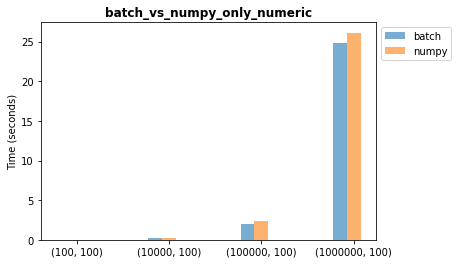

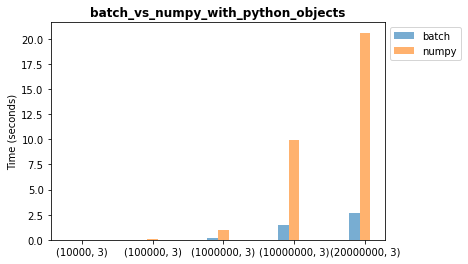

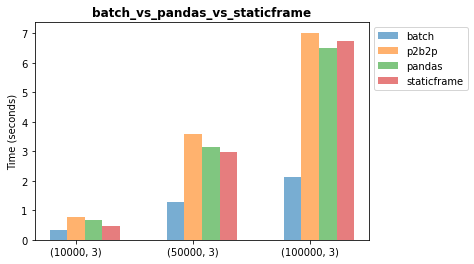

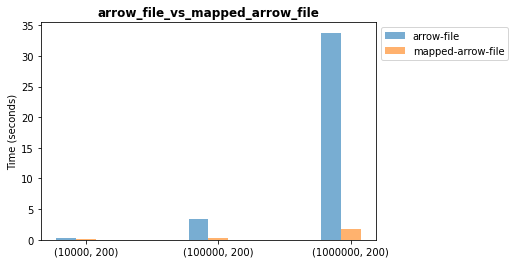

In [45]:
import pandas as pd
def plot_test(filename, title):
    df = pd.read_csv(filename)
    df['method']=df['label'].map(lambda z: z.split('_')[0])
    df['rows']=df['label'].map(lambda z: tuple(map(int, z.split('_')[1:])))
    data = dict()
    df = df.sort_values('rows')
    for k, v2 in df.groupby('method'):
        g = v2.sort_index()['duration'].values.tolist()
        data[k]=g
    labels = []
    for k, _ in df.groupby('rows'):
        labels.append(str(k))
    #print(labels)
    #print(data)
    plot(data, labels, title, 0)

plot_test('/tmp/test1.txt', 'batch_vs_numpy_only_numeric')
plot_test('/tmp/test2.txt', 'batch_vs_numpy_with_python_objects')
plot_test('/tmp/test3.txt', 'batch_vs_pandas_vs_staticframe')
plot_test('/tmp/test4.txt', 'arrow_file_vs_mapped_arrow_file')

